In [1]:
#from bs4 import BeautifulSoup
import requests
#import urllib.request
#from tqdm import tqdm
#from dateutil import parser
import pandas as pd
import os
from datetime import date, datetime
import psycopg2
import requests
import json
import pandas as pd
import http.client

In [ ]:

df1 = pd.DataFrame(columns=['Team','League','Attack','Midfield','Defence','Overall'])


for l in tqdm(range(1, 21,1)):
    r = requests.get('https://www.fifaindex.com/teams/?page='+str(l))
    soup = BeautifulSoup(r.content)
    
    team_n = soup.find_all('td', {"data-title":["Name"]})
    team_name = [a.text for a in team_n]
    leagues = soup.find_all('td',{'data-title':['League']})
    league = [l.text for l in leagues]
    attacks = soup.find_all('td',{'data-title':['ATT']})
    attack = [at.text for at in attacks]
    midfields = soup.find_all('td',{'data-title':['MID']})
    midfield = [md.text for md in midfields]
    defences = soup.find_all('td',{'data-title':['DEF']})
    defence = [df.text for df in defences]
    overalls = soup.find_all('td',{'data-title':['OVR']})
    overall = [ov.text for ov in overalls]
    
    df = pd.DataFrame({'Team':team_name,'League':league, 'Attack':attack, 'Midfield':midfield,'Defence':defence, 'Overall':overall})

    df1 = df1.append(df, ignore_index=True)
    #df1.concat(pd.DataFrame([i], columns=['A'])
df1.head(20)


In [ ]:
df1['submitted_date'] = date.today()
df1.to_csv('/Users/smarino/workspace/Football-Prediction/footballPrediction-project/fifa-teams.csv', index=False)

In [ ]:
#football results
#get data from football-data.co.uk

S_1920 = 'https://www.football-data.co.uk/mmz4281/1192/E0.csv'
df_results = pd.read_csv('https://www.football-data.co.uk/mmz4281/1819/E0.csv', usecols=['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR'])
df_results.to_csv('/Users/smarino/workspace/Football-Prediction/footballPrediction-project/results18_19.csv')


In [ ]:

connection = http.client.HTTPConnection('api.football-data.org')
headers = { 'X-Auth-Token': '9976af08984d4611a0128e358f5b1178' }
connection.request('GET', '/v2/competitions/ELC/matches', None, headers )
response = json.loads(connection.getresponse().read().decode())



In [ ]:
print(response)

In [ ]:
print(response['competition']['name'])

In [ ]:
match_date = []
home_team = []
away_team = []
competition = response['competition']['name']

for i in range(len(response['matches'])):
    match_date.append(response['matches'][i]['utcDate'])
    home_team.append(response['matches'][i]['homeTeam']['name'])
    away_team.append(response['matches'][i]['awayTeam']['name'])
    
df_fixtures = pd.DataFrame({'match_date':match_date, 'competition':competition,'home_team':home_team, 'away_team':away_team})
df_fixtures['match_date'] = df_fixtures['match_date'].apply(lambda x: datetime.fromisoformat(x[:-10]))
df_fixtures.head()

In [2]:
con = psycopg2.connect("dbname=predictordb host=localhost port=5432 user=postgres password=Chelsea1417$")
cur = con.cursor()

In [ ]:
#df_fixtures.to_csv('/Users/smarino/workspace/Football-Prediction/footballPrediction-project/champ_fixtures.csv')

In [ ]:
sql = '''select schemaname as table_schema,
       relname as table_name,
       pg_size_pretty(pg_relation_size(relid)) as data_size
from pg_catalog.pg_statio_user_tables
order by pg_relation_size(relid) desc;
'''
df = pd.read_sql(sql, con)
print(df)

In [ ]:
sql = '''select column_name
from information_schema.columns where table_name = 'predictions_team';
'''
df = pd.read_sql(sql, con)
print(df)

In [ ]:
sql6 = '''select * from predictions_results where (home_team = 'Chelsea' or away_team = 'Chelsea') '''
df = pd.read_sql(sql6, con)
df.tail()

In [ ]:
sql = (
    "with data as ("
    "select match_date, 'Chelsea' as Team, "
    "case when home_team = 'Chelsea' then 'H' else 'A' end as H_or_A, fthg, ftag, ftr "
    "from predictions_results "
    "where (home_team = 'Chelsea' or away_team = 'Chelsea') "
    "order by match_date desc "
    "LIMIT 5 ),"
    "summary as (select match_date, Team, h_or_a, "
    "case when h_or_a = 'H' then fthg else 0 end home_goals, "
    "case when h_or_a = 'A' then ftag else 0 end away_goals, "
    "case when h_or_a = 'A' and ftr = 'A' then 3 "
    "when h_or_a = 'H' and ftr = 'H' then 3 "
    "when h_or_a = 'H' and ftr = 'A' then 0 "
    "when h_or_a = 'A' and ftr = 'H' then 0 "
    "else 1 end points, "
    "ftr "
    "from data order by 1 desc), "
    "team as (select team, attack, midfield, defence, overall from predictions_team where team = 'Chelsea' ) "
    "select t.team, avg(home_goals) avg_h_goals, avg(away_goals) avg_a_goals, avg(points) avg_points, t.attack, "
    "t.midfield, t.defence, t.defence, t.overall "
    "from summary s "
    "join team t on s.team = t.team "
    "group by 1,5,6,7,8,9"
)
df = pd.read_sql(sql, con)
df.head()

In [ ]:
sql = (
    "with data as ("
    "select match_date, 'Chelsea' as Team, "
    "case when home_team = 'Chelsea' then 'H' else 'A' end as H_or_A, fthg, ftag, ftr "
    "from predictions_results "
    "where (home_team = 'Chelsea' or away_team = 'Chelsea') "
    "order by match_date desc "
    "LIMIT 5 ),"
    "summary as (select match_date, Team, h_or_a, "
    "case when h_or_a = 'H' then fthg else 0 end home_goals, "
    "case when h_or_a = 'A' then ftag else 0 end away_goals, "
    "case when h_or_a = 'A' and ftr = 'A' then 3 "
    "when h_or_a = 'H' and ftr = 'H' then 3 "
    "when h_or_a = 'H' and ftr = 'A' then 0 "
    "when h_or_a = 'A' and ftr = 'H' then 0 "
    "else 1 end points, "
    "ftr "
    "from data order by 1 desc), "
    "team as (select team, attack, midfield, defence, overall from predictions_team where team = 'Chelsea' ) "
    "select t.team, avg(home_goals) avg_h_goals, avg(away_goals) avg_a_goals, avg(points) avg_points, t.attack, "
    "t.midfield, t.defence, t.defence, t.overall "
    "from summary s "
    "join team t on s.team = t.team "
    "group by 1,5,6,7,8,9"
)
df = pd.read_sql(sql, con)
df.head()

In [ ]:
teams_sql = ("select distinct team from predictions_team where league in ('Premier League','EFL Championship')")
teams1 = pd.read_sql(teams_sql, con)
teams1.sort_values('team', ascending=True, ignore_index=True, inplace=True)
teams1

In [ ]:
#check if Fifa team ratings have been updated
#new implemenation for connecting to FIFA data - where match date is greater than submitted date (next)



In [3]:
teams_sql = ("with data as ( "
             "select distinct home_team team from predictions_results "
             "union all "
             "select distinct away_team team from predictions_results) "
             "select distinct team from data")
teams2 = pd.read_sql(teams_sql, con)
teams2.sort_values('team', ascending=True, ignore_index=True, inplace=True)
teams2

,team
0,AFC Bournemouth
1,Arsenal
2,Aston Villa
3,Brentford
4,Brighton & Hove Albion
5,Burnley
6,Cardiff City
7,Chelsea
8,Crystal Palace
9,Everton


In [ ]:
#['Chelsea' 'Burnley' 'Everton' 'Fulham' 'Aston Villa' 'Liverpool'
#'Crystal Palace' 'Arsenal' 'Watford' 'Southampton' 'Sheffield United']
#DANGEROUS - be careful when running

for i in range(len(lst_sql)):
    sql_update = (lst_sql[i])
    cursor = con.cursor()
    cursor.execute(sql_update)
    con.commit()

In [ ]:
lst_sql = [
    
    "UPDATE predictions_results SET home_team = 'Wolverhampton Wanderers' WHERE home_team = 'Wolves';",
    "UPDATE predictions_results SET away_team = 'Wolverhampton Wanderers' WHERE away_team = 'Wolves';",
    "UPDATE predictions_results SET home_team = 'Newcastle United' WHERE home_team = 'Newcastle';",
    "UPDATE predictions_results SET away_team = 'Newcastle United' WHERE away_team = 'Newcastle';",
    "UPDATE predictions_results SET home_team = 'West Ham United' WHERE home_team = 'West Ham';",
    "UPDATE predictions_results SET away_team = 'West Ham United' WHERE away_team = 'West Ham';",
    "UPDATE predictions_results SET home_team = 'Tottenham Hotspur' WHERE home_team = 'Tottenham';",
    "UPDATE predictions_results SET away_team = 'Tottenham Hotspur' WHERE away_team = 'Tottenham';",
    "UPDATE predictions_results SET home_team = 'Norwich City' WHERE home_team = 'Norwich';",
    "UPDATE predictions_results SET away_team = 'Norwich City' WHERE away_team = 'Norwich';",
    "UPDATE predictions_results SET home_team = 'Manchester United' WHERE home_team = 'Man United';",
    "UPDATE predictions_results SET away_team = 'Manchester United' WHERE away_team = 'Man United';",
    "UPDATE predictions_results SET home_team = 'Manchester City' WHERE home_team = 'Man City';",
    "UPDATE predictions_results SET away_team = 'Manchester City' WHERE away_team = 'Man City';",
    "UPDATE predictions_results SET home_team = 'Leicester City' WHERE home_team = 'Leicester';",
    "UPDATE predictions_results SET away_team = 'Leicester City' WHERE away_team = 'Leicester';",
    "UPDATE predictions_results SET away_team = 'Huddersfield Town' WHERE away_team = 'Huddersfield';",
    "UPDATE predictions_results SET home_team = 'Huddersfield Town' WHERE home_team = 'Huddersfield';",
    "UPDATE predictions_results SET away_team = 'Cardiff City' WHERE away_team = 'Cardiff';",
    "UPDATE predictions_results SET home_team = 'Cardiff City' WHERE home_team = 'Cardiff';",  
    "UPDATE predictions_results SET away_team = 'Brighton & Hove Albion' WHERE away_team = 'Brighton';",
    "UPDATE predictions_results SET home_team = 'Brighton & Hove Albion' WHERE home_team = 'Brighton';", 
    "UPDATE predictions_results SET away_team = 'AFC Bournemouth' WHERE away_team = 'Bournemouth';",
    "UPDATE predictions_results SET home_team = 'AFC Bournemouth' WHERE home_team = 'Bournemouth';" 
]

In [4]:
full_df = []
for index, row in teams2.iterrows():
    sql = (
        "with data as ("
        "select match_date, '" + row['team'] + "' as Team, "
        "case when home_team = '" + row['team'] + "' then 'H' else 'A' end as H_or_A, fthg, ftag, ftr "
        "from predictions_results "
        "where (home_team = '" + row['team'] + "' or away_team = '" + row['team'] +"') "
        "order by match_date asc ),"
        "summary as (select match_date, Team, h_or_a, "
        "case when h_or_a = 'H' then fthg end home_goals, "
        "case when h_or_a = 'H' then ftag  end home_goals_concede, "
        "case when h_or_a = 'A' then ftag  end away_goals, "
        "case when h_or_a = 'A' then fthg  end away_goals_concede, "
        "case when h_or_a = 'A' and ftr = 'A' then 3 "
        "when h_or_a = 'H' and ftr = 'H' then 3 "
        "when h_or_a = 'H' and ftr = 'A' then 0 "
        "when h_or_a = 'A' and ftr = 'H' then 0 "
        "else 1 end points, "
        "ftr "
        "from data order by 1 desc), "
        "team as (select team, attack, midfield, defence, overall from predictions_team where team = '" + row['team'] + "' ) "
        "select s.match_date, t.team, "
        "avg(home_goals) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_h_goals_scored, "
        "avg(home_goals_concede) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_h_goals_concede, "
        "avg(away_goals) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_a_goals_scored, "
        "avg(away_goals_concede) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_a_goals_concede, "
        "avg(points) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_points, "
        "t.attack, t.midfield, t.defence, t.overall "
        "from summary s "
        "join team t on s.team = t.team "
        "order by 1"
        
    )
    df = pd.read_sql(sql, con)
    full_df.append(df)

full_df = pd.concat(full_df)
full_df.head()
 

,match_date,team,avg_h_goals_scored,avg_h_goals_concede,avg_a_goals_scored,avg_a_goals_concede,avg_points,attack,midfield,defence,overall
0,2018-08-11,AFC Bournemouth,NaN,NaN,NaN,NaN,NaN,72,75,71,74
1,2018-08-18,AFC Bournemouth,2.0,0.0,NaN,NaN,3.000000,72,75,71,74
2,2018-08-25,AFC Bournemouth,2.0,0.0,2.0,1.0,3.000000,72,75,71,74
3,2018-09-01,AFC Bournemouth,2.0,1.0,2.0,1.0,2.333333,72,75,71,74
4,2018-09-15,AFC Bournemouth,2.0,1.0,1.0,1.5,1.750000,72,75,71,74


In [5]:
#print(full_df['team'].unique())
full_df.fillna(0, inplace=True)
full_df.head()

,match_date,team,avg_h_goals_scored,avg_h_goals_concede,avg_a_goals_scored,avg_a_goals_concede,avg_points,attack,midfield,defence,overall
0,2018-08-11,AFC Bournemouth,0.0,0.0,0.0,0.0,0.000000,72,75,71,74
1,2018-08-18,AFC Bournemouth,2.0,0.0,0.0,0.0,3.000000,72,75,71,74
2,2018-08-25,AFC Bournemouth,2.0,0.0,2.0,1.0,3.000000,72,75,71,74
3,2018-09-01,AFC Bournemouth,2.0,1.0,2.0,1.0,2.333333,72,75,71,74
4,2018-09-15,AFC Bournemouth,2.0,1.0,1.0,1.5,1.750000,72,75,71,74


In [6]:
results_home = ("select match_date||home_team||away_team key1, match_date, home_team team, ftr from predictions_results ")
results_home = pd.read_sql(results_home, con)
results_home.head()

,key1,match_date,team,ftr
0,2020-09-12FulhamArsenal,2020-09-12,Fulham,A
1,2020-09-12Crystal PalaceSouthampton,2020-09-12,Crystal Palace,H
2,2018-08-26Newcastle UnitedChelsea,2018-08-26,Newcastle United,A
3,2018-09-15Newcastle UnitedArsenal,2018-09-15,Newcastle United,A
4,2020-09-20ChelseaLiverpool,2020-09-20,Chelsea,A


In [7]:
results_away = ("select match_date||home_team||away_team key1, match_date, away_team team from predictions_results ")
results_away = pd.read_sql(results_away, con)
results_away.head()

,key1,match_date,team
0,2020-09-12FulhamArsenal,2020-09-12,Arsenal
1,2020-09-12Crystal PalaceSouthampton,2020-09-12,Southampton
2,2018-08-26Newcastle UnitedChelsea,2018-08-26,Chelsea
3,2018-09-15Newcastle UnitedArsenal,2018-09-15,Arsenal
4,2020-09-20ChelseaLiverpool,2020-09-20,Liverpool


In [8]:

data_home = pd.merge(results_home, full_df, on=['team','match_date'], how='left')
data_home.columns = ['key1','match_date','home_team','ftr','home_avg_h_goals_scored','home_avg_h_goals_concede',
                   'home_avg_a_goals_scored','home_avg_a_goals_concede','home_avg_points','home_attack', 'home_midfield',
                   'home_defence', 'home_overall']
data_home.sort_values('match_date', ascending=True, ignore_index=True, inplace=True)
print(data_home.info())
data_home.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   key1                      1160 non-null   object 
 1   match_date                1160 non-null   object 
 2   home_team                 1160 non-null   object 
 3   ftr                       1160 non-null   object 
 4   home_avg_h_goals_scored   1160 non-null   float64
 5   home_avg_h_goals_concede  1160 non-null   float64
 6   home_avg_a_goals_scored   1160 non-null   float64
 7   home_avg_a_goals_concede  1160 non-null   float64
 8   home_avg_points           1160 non-null   float64
 9   home_attack               1160 non-null   int64  
 10  home_midfield             1160 non-null   int64  
 11  home_defence              1160 non-null   int64  
 12  home_overall              1160 non-null   int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 117.9+ KB
None

,key1,match_date,home_team,ftr,home_avg_h_goals_scored,home_avg_h_goals_concede,home_avg_a_goals_scored,home_avg_a_goals_concede,home_avg_points,home_attack,home_midfield,home_defence,home_overall
0,2018-08-10Manchester UnitedLeicester City,2018-08-10,Manchester United,H,0.0,0.0,0.0,0.0,0.0,83,82,82,82
1,2018-08-11AFC BournemouthCardiff City,2018-08-11,AFC Bournemouth,H,0.0,0.0,0.0,0.0,0.0,72,75,71,74
2,2018-08-11Huddersfield TownChelsea,2018-08-11,Huddersfield Town,A,0.0,0.0,0.0,0.0,0.0,68,69,69,69
3,2018-08-11WatfordBrighton & Hove Albion,2018-08-11,Watford,H,0.0,0.0,0.0,0.0,0.0,74,74,73,74
4,2018-08-11Wolverhampton WanderersEverton,2018-08-11,Wolverhampton Wanderers,D,0.0,0.0,0.0,0.0,0.0,77,81,78,79


In [9]:
data_away = pd.merge(results_away, full_df, on=['team','match_date'], how='left')
data_away.columns = ['key1','match_date','away_team','away_avg_h_goals_scored','away_avg_h_goals_concede',
                   'away_avg_a_goals_scored','away_avg_a_goals_concede','away_avg_points','away_attack','away_midfield',
                   'away_defence', 'away_overall']
data_away.sort_values('match_date', ascending=True, ignore_index=True, inplace=True)
data_away.head()

,key1,match_date,away_team,away_avg_h_goals_scored,away_avg_h_goals_concede,away_avg_a_goals_scored,away_avg_a_goals_concede,away_avg_points,away_attack,away_midfield,away_defence,away_overall
0,2018-08-10Manchester UnitedLeicester City,2018-08-10,Leicester City,0.0,0.0,0.0,0.0,0.0,80,81,79,80
1,2018-08-11AFC BournemouthCardiff City,2018-08-11,Cardiff City,0.0,0.0,0.0,0.0,0.0,71,71,69,71
2,2018-08-11Huddersfield TownChelsea,2018-08-11,Chelsea,0.0,0.0,0.0,0.0,0.0,82,84,82,82
3,2018-08-11WatfordBrighton & Hove Albion,2018-08-11,Brighton & Hove Albion,0.0,0.0,0.0,0.0,0.0,75,76,76,75
4,2018-08-11Wolverhampton WanderersEverton,2018-08-11,Everton,0.0,0.0,0.0,0.0,0.0,81,79,80,79


In [10]:
full_data = pd.merge(data_home, data_away, on='key1')
full_data.sort_values('match_date_x', ascending=True, ignore_index=True, inplace=True)
full_data.head()

,key1,match_date_x,home_team,ftr,home_avg_h_goals_scored,home_avg_h_goals_concede,home_avg_a_goals_scored,home_avg_a_goals_concede,home_avg_points,home_attack,...,away_team,away_avg_h_goals_scored,away_avg_h_goals_concede,away_avg_a_goals_scored,away_avg_a_goals_concede,away_avg_points,away_attack,away_midfield,away_defence,away_overall
0,2018-08-10Manchester UnitedLeicester City,2018-08-10,Manchester United,H,0.0,0.0,0.0,0.0,0.0,83,...,Leicester City,0.0,0.0,0.0,0.0,0.0,80,81,79,80
1,2018-08-11AFC BournemouthCardiff City,2018-08-11,AFC Bournemouth,H,0.0,0.0,0.0,0.0,0.0,72,...,Cardiff City,0.0,0.0,0.0,0.0,0.0,71,71,69,71
2,2018-08-11Huddersfield TownChelsea,2018-08-11,Huddersfield Town,A,0.0,0.0,0.0,0.0,0.0,68,...,Chelsea,0.0,0.0,0.0,0.0,0.0,82,84,82,82
3,2018-08-11WatfordBrighton & Hove Albion,2018-08-11,Watford,H,0.0,0.0,0.0,0.0,0.0,74,...,Brighton & Hove Albion,0.0,0.0,0.0,0.0,0.0,75,76,76,75
4,2018-08-11Wolverhampton WanderersEverton,2018-08-11,Wolverhampton Wanderers,D,0.0,0.0,0.0,0.0,0.0,77,...,Everton,0.0,0.0,0.0,0.0,0.0,81,79,80,79


In [11]:
data = full_data.copy()

In [12]:
data[data['home_avg_h_goals_scored'].isnull()]

,key1,match_date_x,home_team,ftr,home_avg_h_goals_scored,home_avg_h_goals_concede,home_avg_a_goals_scored,home_avg_a_goals_concede,home_avg_points,home_attack,...,away_team,away_avg_h_goals_scored,away_avg_h_goals_concede,away_avg_a_goals_scored,away_avg_a_goals_concede,away_avg_points,away_attack,away_midfield,away_defence,away_overall


In [ ]:
chelsea = data[(data['home_team'] == 'Chelsea') & (data['away_team'] =='Newcastle United')]
chelsea[:1]

In [ ]:
#Put the data through a simple - logistic regression - what was the outcome
con.close()

In [ ]:
#DANGEROUS!! - do not run

#sql1 = ''' truncate predictions_results '''
#cursor = con.cursor()
#cur.execute(sql1)
#con.commit()

In [ ]:
#correlation matrix of features

In [13]:
data.drop(['key1','match_date_x','home_team','match_date_y','away_team'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ftr                       1160 non-null   object 
 1   home_avg_h_goals_scored   1160 non-null   float64
 2   home_avg_h_goals_concede  1160 non-null   float64
 3   home_avg_a_goals_scored   1160 non-null   float64
 4   home_avg_a_goals_concede  1160 non-null   float64
 5   home_avg_points           1160 non-null   float64
 6   home_attack               1160 non-null   int64  
 7   home_midfield             1160 non-null   int64  
 8   home_defence              1160 non-null   int64  
 9   home_overall              1160 non-null   int64  
 10  away_avg_h_goals_scored   1160 non-null   float64
 11  away_avg_h_goals_concede  1160 non-null   float64
 12  away_avg_a_goals_scored   1160 non-null   float64
 13  away_avg_a_goals_concede  1160 non-null   float64
 14  away_avg

In [14]:
def encoding(x):
    if x == 'H':
        return 1
    if x == 'A':
        return 2
    if x == 'D':
        return 0
    
data['ftr'] = data['ftr'].apply(lambda x: encoding(x))

In [15]:
data.apply(pd.to_numeric)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ftr                       1160 non-null   int64  
 1   home_avg_h_goals_scored   1160 non-null   float64
 2   home_avg_h_goals_concede  1160 non-null   float64
 3   home_avg_a_goals_scored   1160 non-null   float64
 4   home_avg_a_goals_concede  1160 non-null   float64
 5   home_avg_points           1160 non-null   float64
 6   home_attack               1160 non-null   int64  
 7   home_midfield             1160 non-null   int64  
 8   home_defence              1160 non-null   int64  
 9   home_overall              1160 non-null   int64  
 10  away_avg_h_goals_scored   1160 non-null   float64
 11  away_avg_h_goals_concede  1160 non-null   float64
 12  away_avg_a_goals_scored   1160 non-null   float64
 13  away_avg_a_goals_concede  1160 non-null   float64
 14  away_avg

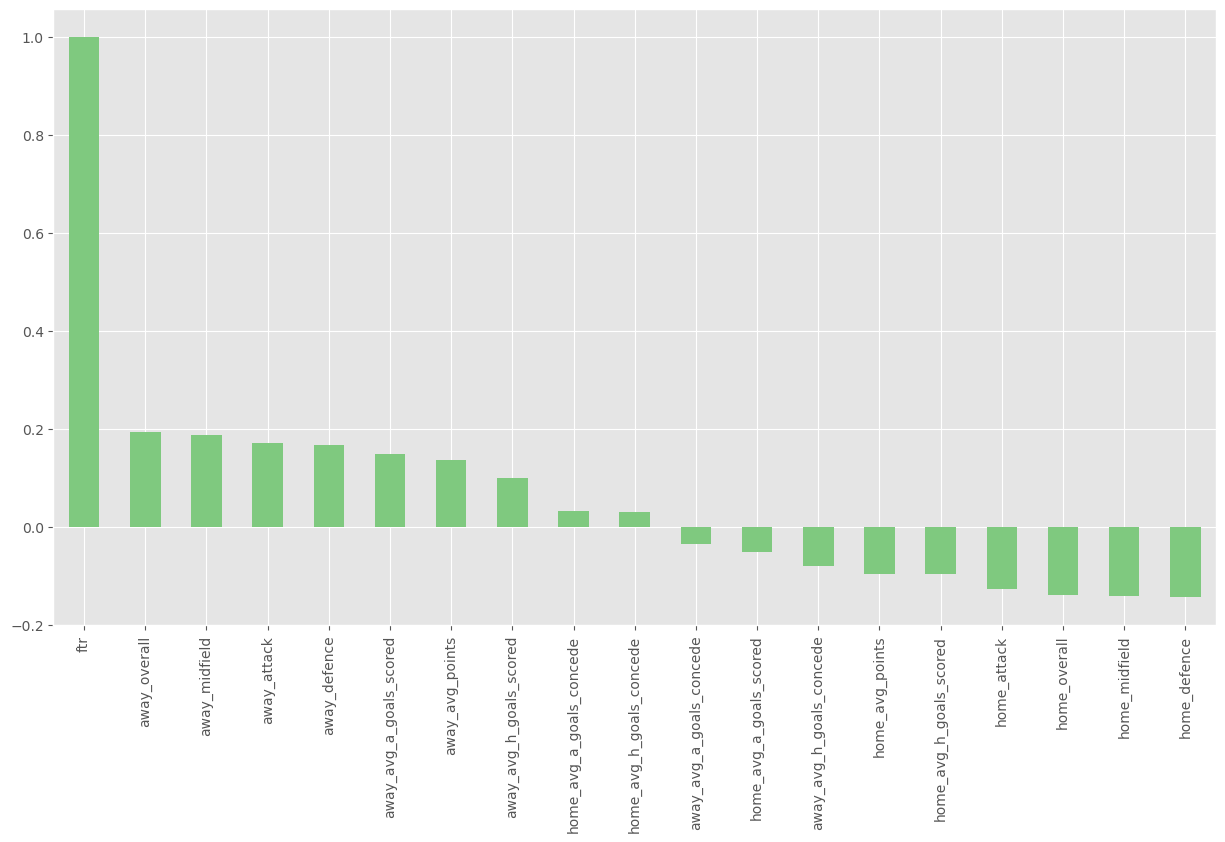

In [16]:
#VISUALISATION
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(15,8))
plt.style.use('ggplot')
my_cmap = cm.get_cmap('Accent')


correlations = data.corr()['ftr'].sort_values(ascending = False)
correlations.plot(kind='bar', cmap=my_cmap)
plt.show() 

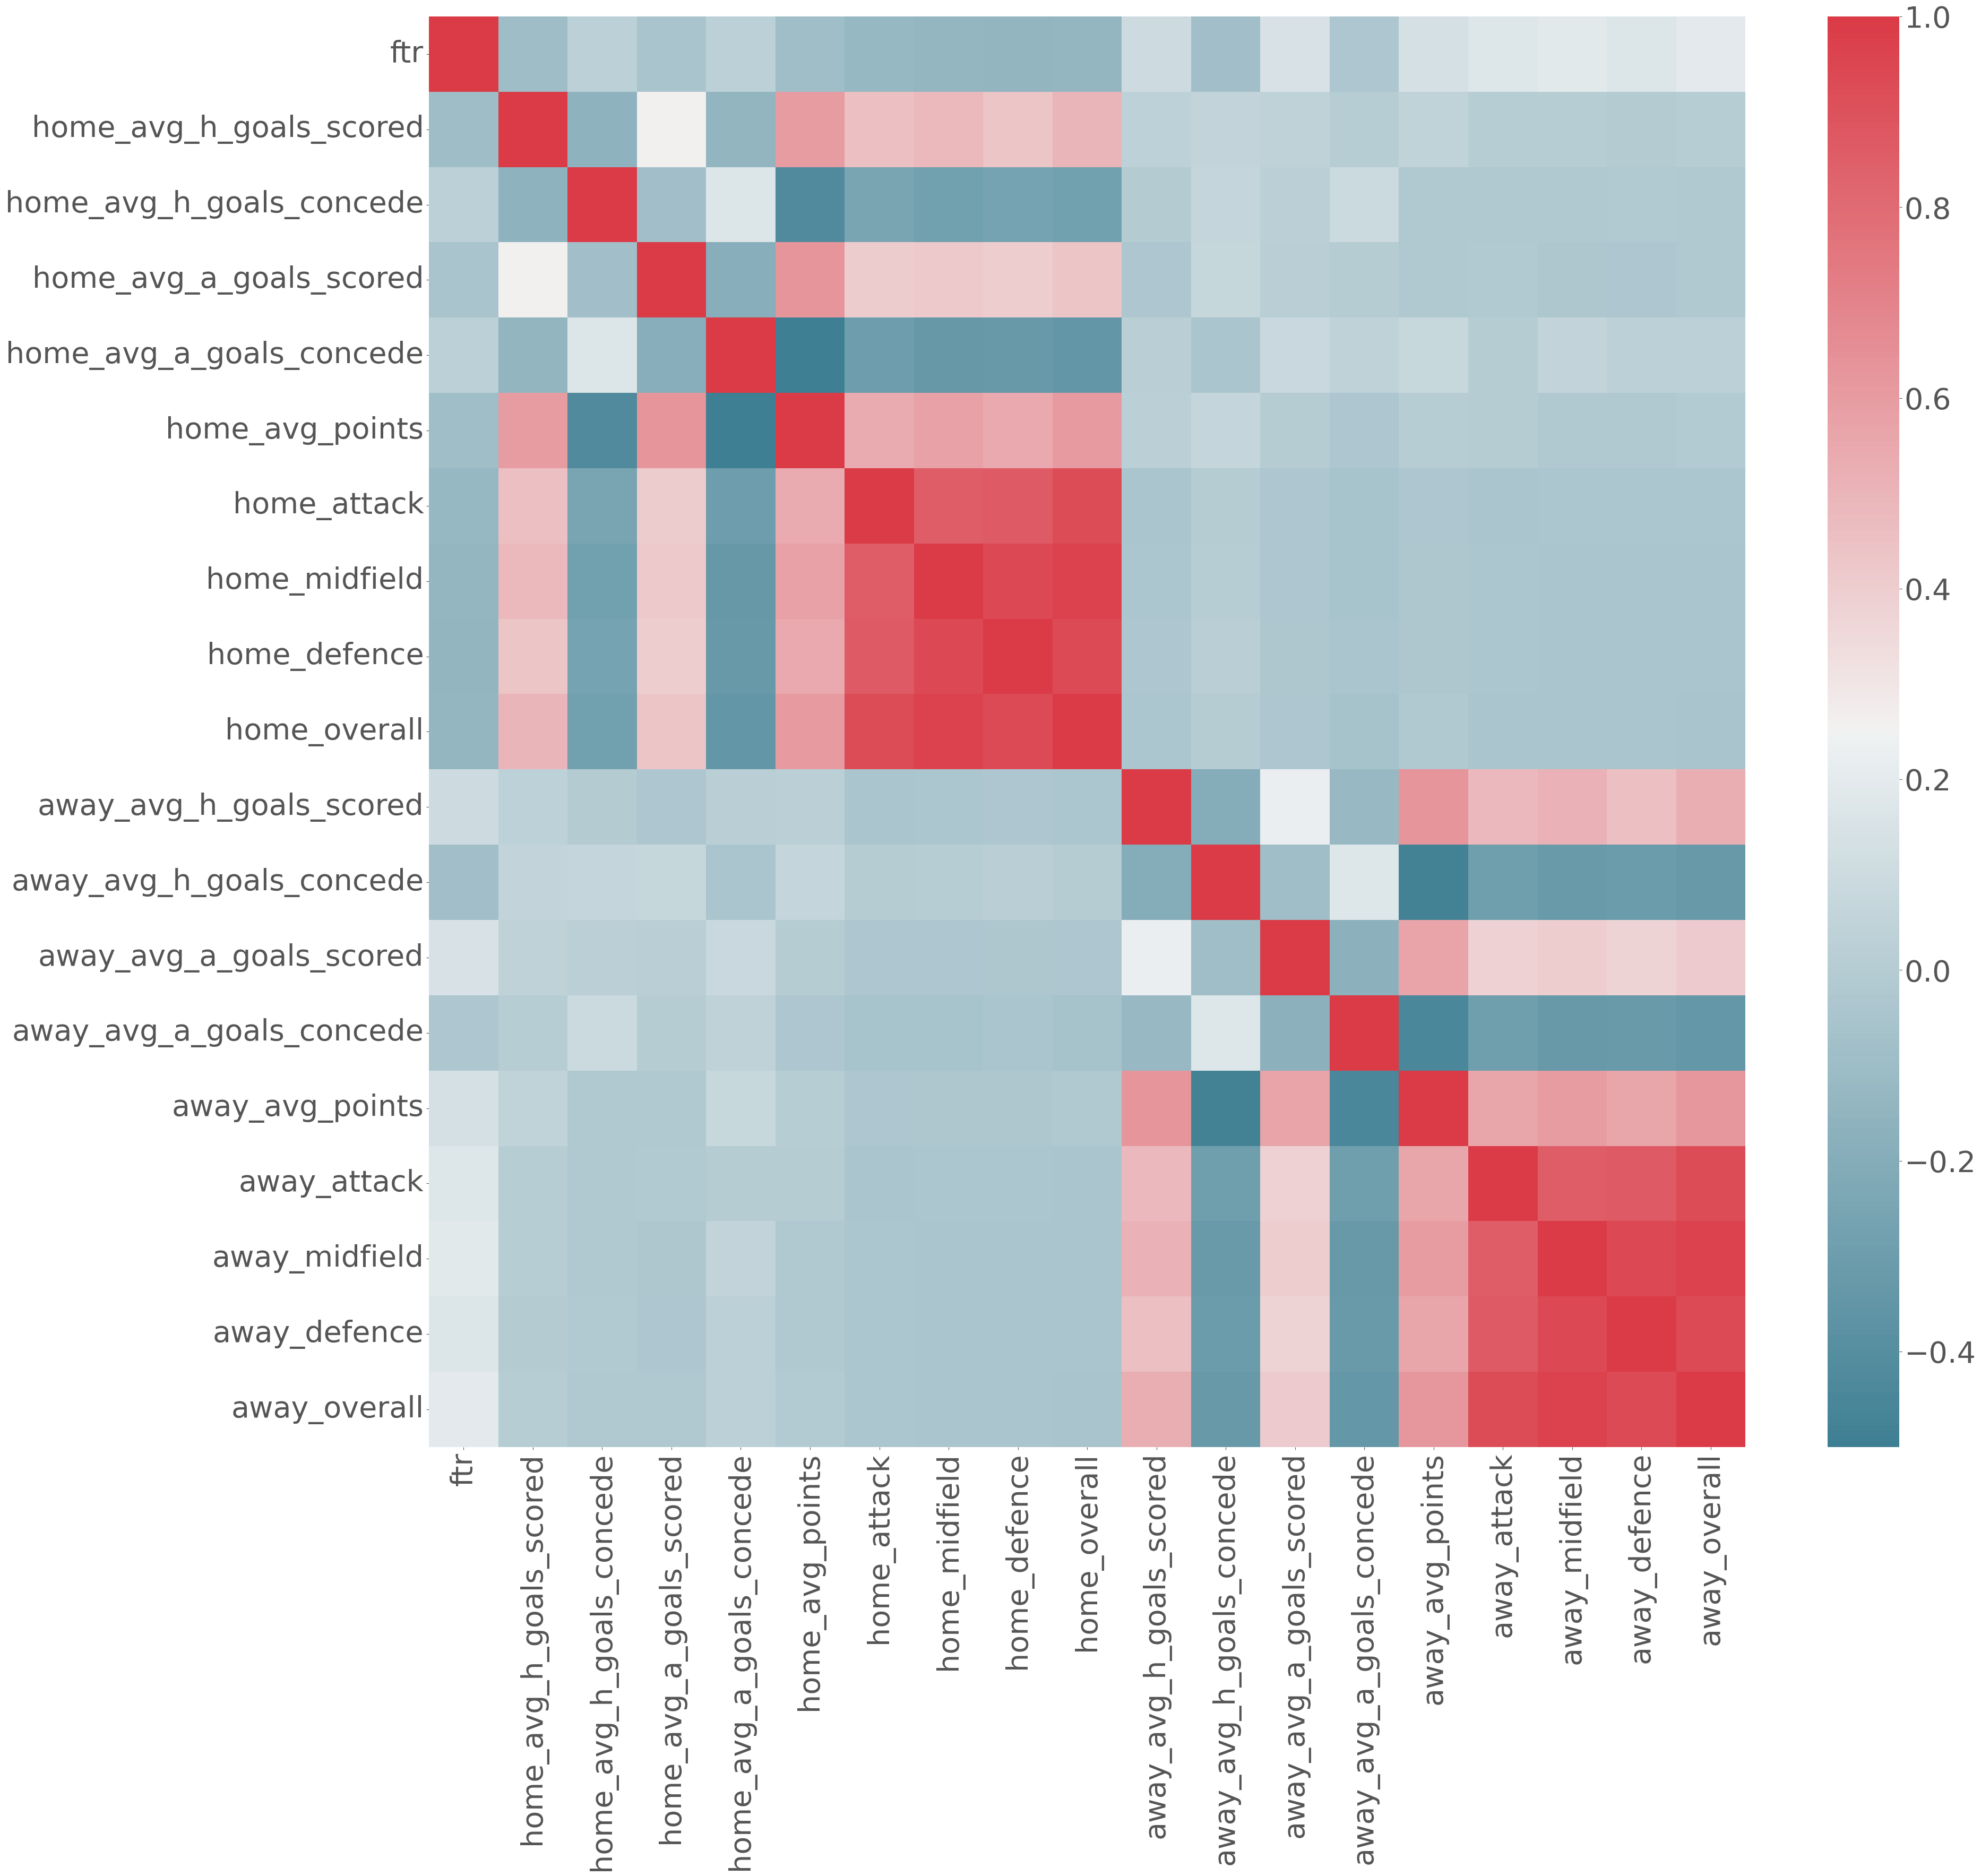

In [17]:
import seaborn as sns
cor = data.corr()
plt.figure(figsize=(40,35))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(cor, annot=False, cmap=cmap)#cmap="YlGnBu")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 40,rotation=90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 40,rotation=360)
ax.figure.axes[-1].tick_params(labelsize=40)
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler


%load_ext autoreload
%autoreload 2

# making all pandas columns visable with display command
pd.set_option('display.max_columns', 500)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [19]:
#split the data and prep for NN
Y = data['ftr']
X = data.drop(['ftr'], axis=1, inplace=True)
X = data.values

In [20]:


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)


In [21]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [22]:
columns = X_train.shape[1]
columns

18

In [23]:
x = Input(shape=(columns,))
layer = Flatten()(x)
layer = Dense(18, activation='relu')(x)
layer = Dense(8, activation='relu')(layer)
layer = Dropout(0.3)(layer)
output = Dense(3, activation='softmax')(layer)

model = Model(inputs=x, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, batch_size=16, epochs=250, validation_split=0.04)

Train on 745 samples, validate on 32 samples
Epoch 1/250
745/745 [==============================] - 1s 918us/sample - loss: 1.0575 - accuracy: 0.4725 - val_loss: 0.8918 - val_accuracy: 0.6875
Epoch 2/250
745/745 [==============================] - 0s 113us/sample - loss: 0.9908 - accuracy: 0.5423 - val_loss: 0.8509 - val_accuracy: 0.6875
Epoch 3/250
745/745 [==============================] - 0s 115us/sample - loss: 0.9640 - accuracy: 0.5477 - val_loss: 0.8389 - val_accuracy: 0.6875
Epoch 4/250
745/745 [==============================] - 0s 122us/sample - loss: 0.9627 - accuracy: 0.5503 - val_loss: 0.8582 - val_accuracy: 0.6562
Epoch 5/250
745/745 [==============================] - 0s 111us/sample - loss: 0.9612 - accuracy: 0.5624 - val_loss: 0.8088 - val_accuracy: 0.6875
Epoch 6/250
745/745 [==============================] - 0s 103us/sample - loss: 0.9464 - accuracy: 0.5718 - val_loss: 0.8627 - val_accuracy: 0.6250
Epoch 7/250
745/745 [==============================] - 0s 98us/sample - l

745/745 [==============================] - 0s 98us/sample - loss: 0.7377 - accuracy: 0.6483 - val_loss: 1.3360 - val_accuracy: 0.4688
Epoch 57/250
745/745 [==============================] - 0s 97us/sample - loss: 0.7360 - accuracy: 0.6430 - val_loss: 1.3048 - val_accuracy: 0.4688
Epoch 58/250
745/745 [==============================] - 0s 96us/sample - loss: 0.7503 - accuracy: 0.6322 - val_loss: 1.3166 - val_accuracy: 0.4688
Epoch 59/250
745/745 [==============================] - 0s 97us/sample - loss: 0.7540 - accuracy: 0.6362 - val_loss: 1.2543 - val_accuracy: 0.5000
Epoch 60/250
745/745 [==============================] - 0s 94us/sample - loss: 0.7509 - accuracy: 0.6376 - val_loss: 1.1977 - val_accuracy: 0.5000
Epoch 61/250
745/745 [==============================] - 0s 95us/sample - loss: 0.7163 - accuracy: 0.6564 - val_loss: 1.3224 - val_accuracy: 0.5000
Epoch 62/250
745/745 [==============================] - 0s 96us/sample - loss: 0.7634 - accuracy: 0.6215 - val_loss: 1.1741 - val_a

745/745 [==============================] - 0s 95us/sample - loss: 0.7001 - accuracy: 0.6336 - val_loss: 1.6610 - val_accuracy: 0.4688
Epoch 112/250
745/745 [==============================] - 0s 96us/sample - loss: 0.6628 - accuracy: 0.6523 - val_loss: 1.7947 - val_accuracy: 0.4688
Epoch 113/250
745/745 [==============================] - 0s 97us/sample - loss: 0.6943 - accuracy: 0.6389 - val_loss: 1.8473 - val_accuracy: 0.5312
Epoch 114/250
745/745 [==============================] - 0s 94us/sample - loss: 0.6804 - accuracy: 0.6456 - val_loss: 2.0740 - val_accuracy: 0.4688
Epoch 115/250
745/745 [==============================] - 0s 95us/sample - loss: 0.6819 - accuracy: 0.6403 - val_loss: 1.8637 - val_accuracy: 0.4688
Epoch 116/250
745/745 [==============================] - 0s 95us/sample - loss: 0.6768 - accuracy: 0.6470 - val_loss: 1.9255 - val_accuracy: 0.4375
Epoch 117/250
745/745 [==============================] - 0s 94us/sample - loss: 0.6434 - accuracy: 0.6577 - val_loss: 2.4427 -

745/745 [==============================] - 0s 99us/sample - loss: 0.6685 - accuracy: 0.6295 - val_loss: 3.5252 - val_accuracy: 0.5000
Epoch 167/250
745/745 [==============================] - 0s 98us/sample - loss: 0.6627 - accuracy: 0.6268 - val_loss: 2.6444 - val_accuracy: 0.4688
Epoch 168/250
745/745 [==============================] - 0s 96us/sample - loss: 0.7068 - accuracy: 0.6510 - val_loss: 2.2202 - val_accuracy: 0.5000
Epoch 169/250
745/745 [==============================] - 0s 94us/sample - loss: 0.6682 - accuracy: 0.6121 - val_loss: 2.4926 - val_accuracy: 0.5312
Epoch 170/250
745/745 [==============================] - 0s 95us/sample - loss: 0.6581 - accuracy: 0.6443 - val_loss: 2.7758 - val_accuracy: 0.5312
Epoch 171/250
745/745 [==============================] - 0s 94us/sample - loss: 0.6406 - accuracy: 0.6483 - val_loss: 2.2267 - val_accuracy: 0.5000
Epoch 172/250
745/745 [==============================] - 0s 94us/sample - loss: 0.6832 - accuracy: 0.6483 - val_loss: 2.4151 -

745/745 [==============================] - 0s 104us/sample - loss: 0.6286 - accuracy: 0.6631 - val_loss: 2.4767 - val_accuracy: 0.4688
Epoch 222/250
745/745 [==============================] - 0s 102us/sample - loss: 0.6245 - accuracy: 0.6443 - val_loss: 2.7831 - val_accuracy: 0.4062
Epoch 223/250
745/745 [==============================] - 0s 104us/sample - loss: 0.6323 - accuracy: 0.6617 - val_loss: 2.6727 - val_accuracy: 0.3750
Epoch 224/250
745/745 [==============================] - 0s 97us/sample - loss: 0.6151 - accuracy: 0.6658 - val_loss: 3.1679 - val_accuracy: 0.4688
Epoch 225/250
745/745 [==============================] - 0s 96us/sample - loss: 0.6463 - accuracy: 0.6443 - val_loss: 2.8300 - val_accuracy: 0.4062
Epoch 226/250
745/745 [==============================] - 0s 95us/sample - loss: 0.6718 - accuracy: 0.6523 - val_loss: 2.6742 - val_accuracy: 0.5000
Epoch 227/250
745/745 [==============================] - 0s 102us/sample - loss: 0.6497 - accuracy: 0.6470 - val_loss: 2.90

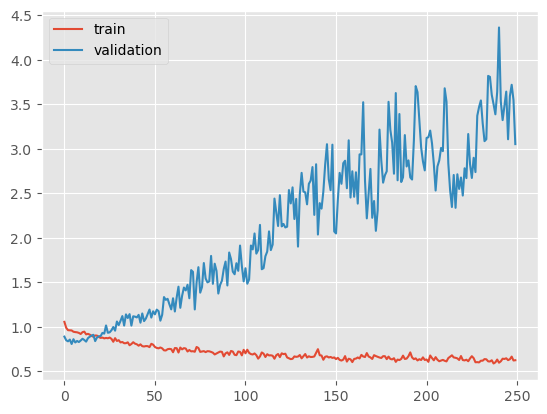

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

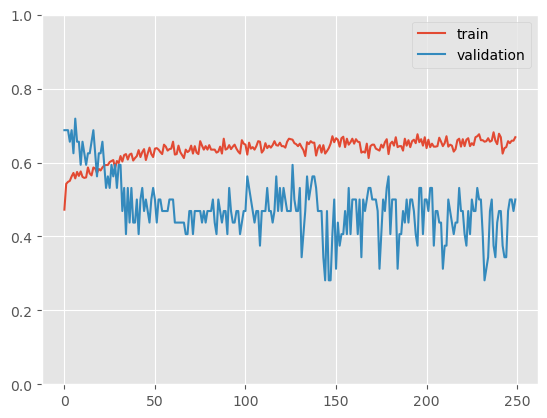

In [26]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylim(0,1)
plt.legend()
plt.show()

In [27]:
#initial Neural Network Model - Accuracy
test_predictions = np.argmax(model.predict(X_test), axis=1)
accuracy = (test_predictions == y_test).sum() / y_test.shape[0]
print("Test set accuracy:", accuracy)


Test set accuracy: 0.5013054830287206


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Create LogisticRegression model
log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [30]:
log_model.fit(X_train, y_train)
#scores1 = cross_val_score(log_model, X_test, y_test, scoring='accuracy', cv=5)
#print(scores1)



y_pred = log_model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  4,  52,  33],
       [  4, 127,  36],
       [  0,  51,  76]])

In [31]:
print("Accuray: ", metrics.accuracy_score(y_test, y_pred))

Accuray:  0.5404699738903395


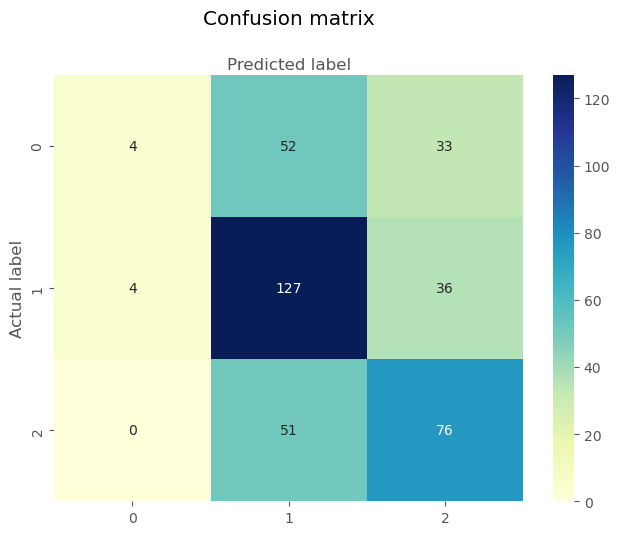

In [32]:
class_names=['draw','home win','away win'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#COEFFICIENT ANALYSIS
coefficients = pd.concat([pd.DataFrame(data.columns),pd.DataFrame(np.transpose(log_model.coef_))], axis = 1)
coefficients = pd.DataFrame(coefficients)
coefficients.to_clipboard()

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [34]:
rf = RandomForestClassifier(n_estimators= 124,
 min_samples_split= 5,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 6,
 bootstrap= True
                           )
rf.fit(X_train, y_train)
y_pred= rf.predict(X_test)

In [35]:

featuresList = list(data.columns) 
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(featuresList, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: home_attack                    Importance: 0.09
Variable: home_overall                   Importance: 0.08
Variable: away_defence                   Importance: 0.07
Variable: away_overall                   Importance: 0.07
Variable: home_midfield                  Importance: 0.06
Variable: home_defence                   Importance: 0.06
Variable: away_avg_a_goals_scored        Importance: 0.06
Variable: away_midfield                  Importance: 0.06
Variable: home_avg_a_goals_concede       Importance: 0.05
Variable: home_avg_points                Importance: 0.05
Variable: away_avg_a_goals_concede       Importance: 0.05
Variable: away_avg_points                Importance: 0.05
Variable: away_attack                    Importance: 0.05
Variable: home_avg_h_goals_scored        Importance: 0.04
Variable: home_avg_h_goals_concede       Importance: 0.04
Variable: home_avg_a_goals_scored        Importance: 0.04
Variable: away_avg_h_goals_scored        Importance: 0.04
Variable: away

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [36]:
rf.score(X_test, y_test)

0.5483028720626631

In [37]:
y_pred = rf.predict(X_test)
cnf_matrix_rf = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_rf

array([[  0,  50,  39],
       [  0, 125,  42],
       [  0,  42,  85]])

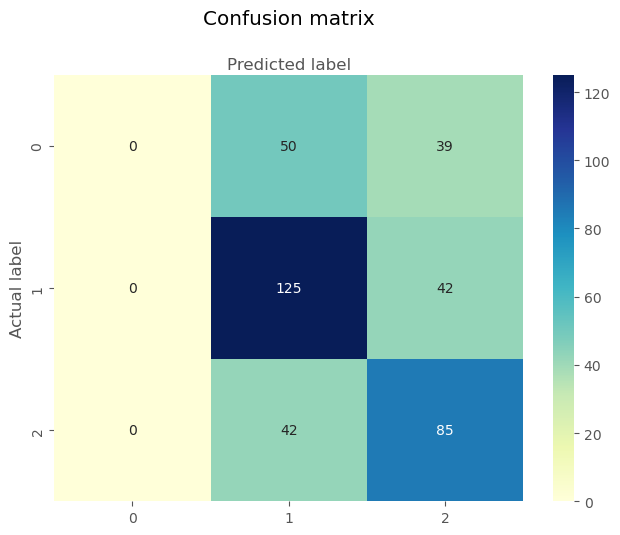

In [38]:
class_names=['draw','home win','away win'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [39]:
#data2
#decision tree shows that for an away team home form is unimportant and for an home team away form is not important

data2 = full_data.copy()
data2.drop(['key1','match_date_x','home_team','match_date_y','away_team','away_avg_h_goals_scored','away_avg_h_goals_concede',
           'home_avg_a_goals_scored','home_avg_a_goals_concede'], axis=1, inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ftr                       1160 non-null   object 
 1   home_avg_h_goals_scored   1160 non-null   float64
 2   home_avg_h_goals_concede  1160 non-null   float64
 3   home_avg_points           1160 non-null   float64
 4   home_attack               1160 non-null   int64  
 5   home_midfield             1160 non-null   int64  
 6   home_defence              1160 non-null   int64  
 7   home_overall              1160 non-null   int64  
 8   away_avg_a_goals_scored   1160 non-null   float64
 9   away_avg_a_goals_concede  1160 non-null   float64
 10  away_avg_points           1160 non-null   float64
 11  away_attack               1160 non-null   int64  
 12  away_midfield             1160 non-null   int64  
 13  away_defence              1160 non-null   int64  
 14  away_ove

In [40]:
def encoding(x):
    if x == 'H':
        return 1
    if x == 'A':
        return 2
    if x == 'D':
        return 0
    
data2['ftr'] = data2['ftr'].apply(lambda x: encoding(x))

In [41]:
data2.apply(pd.to_numeric)
#split the data and prep for NN
Y = data2['ftr']
X = data2.drop(['ftr'], axis=1, inplace=True)
X = data2.values

In [42]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, )

In [43]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
columns = X_train.shape[1]
columns

14

In [51]:
x = Input(shape=(columns,))
layer = Flatten()(x)
layer = Dense(9, activation='relu')(x)
layer = Dense(5, activation='relu')(layer)
layer = Dropout(0.3)(layer)
output = Dense(3, activation='softmax')(layer)

model = Model(inputs=x, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_split=0.04)

Train on 779 samples, validate on 33 samples
Epoch 1/200
779/779 [==============================] - 1s 806us/sample - loss: 1.3909 - accuracy: 0.2721 - val_loss: 1.4510 - val_accuracy: 0.2424
Epoch 2/200
779/779 [==============================] - 0s 111us/sample - loss: 1.3866 - accuracy: 0.2529 - val_loss: 1.4288 - val_accuracy: 0.2121
Epoch 3/200
779/779 [==============================] - 0s 106us/sample - loss: 1.3486 - accuracy: 0.2824 - val_loss: 1.4067 - val_accuracy: 0.2121
Epoch 4/200
779/779 [==============================] - 0s 106us/sample - loss: 1.3071 - accuracy: 0.2824 - val_loss: 1.3885 - val_accuracy: 0.2121
Epoch 5/200
779/779 [==============================] - 0s 105us/sample - loss: 1.3000 - accuracy: 0.2811 - val_loss: 1.3705 - val_accuracy: 0.2424
Epoch 6/200
779/779 [==============================] - 0s 109us/sample - loss: 1.2832 - accuracy: 0.3017 - val_loss: 1.3528 - val_accuracy: 0.2424
Epoch 7/200
779/779 [==============================] - 0s 130us/sample - 

779/779 [==============================] - 0s 102us/sample - loss: 1.0318 - accuracy: 0.4955 - val_loss: 1.1042 - val_accuracy: 0.4545
Epoch 57/200
779/779 [==============================] - 0s 101us/sample - loss: 1.0447 - accuracy: 0.4737 - val_loss: 1.1023 - val_accuracy: 0.4545
Epoch 58/200
779/779 [==============================] - 0s 99us/sample - loss: 1.0459 - accuracy: 0.4865 - val_loss: 1.1009 - val_accuracy: 0.4545
Epoch 59/200
779/779 [==============================] - 0s 97us/sample - loss: 1.0415 - accuracy: 0.4788 - val_loss: 1.1001 - val_accuracy: 0.4545
Epoch 60/200
779/779 [==============================] - 0s 98us/sample - loss: 1.0325 - accuracy: 0.5096 - val_loss: 1.0997 - val_accuracy: 0.4545
Epoch 61/200
779/779 [==============================] - 0s 97us/sample - loss: 1.0375 - accuracy: 0.4891 - val_loss: 1.0989 - val_accuracy: 0.4545
Epoch 62/200
779/779 [==============================] - 0s 118us/sample - loss: 1.0416 - accuracy: 0.4698 - val_loss: 1.0991 - va

779/779 [==============================] - 0s 102us/sample - loss: 1.0088 - accuracy: 0.5032 - val_loss: 1.0693 - val_accuracy: 0.4848
Epoch 112/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9972 - accuracy: 0.5327 - val_loss: 1.0686 - val_accuracy: 0.4848
Epoch 113/200
779/779 [==============================] - 0s 101us/sample - loss: 1.0149 - accuracy: 0.5058 - val_loss: 1.0675 - val_accuracy: 0.4848
Epoch 114/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9972 - accuracy: 0.5199 - val_loss: 1.0663 - val_accuracy: 0.4848
Epoch 115/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9981 - accuracy: 0.5186 - val_loss: 1.0665 - val_accuracy: 0.4848
Epoch 116/200
779/779 [==============================] - 0s 98us/sample - loss: 1.0059 - accuracy: 0.5212 - val_loss: 1.0651 - val_accuracy: 0.4848
Epoch 117/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9952 - accuracy: 0.5263 - val_loss: 1.

779/779 [==============================] - 0s 104us/sample - loss: 0.9972 - accuracy: 0.5058 - val_loss: 1.0513 - val_accuracy: 0.5152
Epoch 167/200
779/779 [==============================] - 0s 103us/sample - loss: 0.9914 - accuracy: 0.5096 - val_loss: 1.0518 - val_accuracy: 0.5152
Epoch 168/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9874 - accuracy: 0.5225 - val_loss: 1.0518 - val_accuracy: 0.5152
Epoch 169/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9892 - accuracy: 0.5122 - val_loss: 1.0509 - val_accuracy: 0.5152
Epoch 170/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9844 - accuracy: 0.5302 - val_loss: 1.0506 - val_accuracy: 0.5152
Epoch 171/200
779/779 [==============================] - 0s 102us/sample - loss: 0.9926 - accuracy: 0.5135 - val_loss: 1.0507 - val_accuracy: 0.5152
Epoch 172/200
779/779 [==============================] - 0s 104us/sample - loss: 0.9954 - accuracy: 0.5250 - val_loss: 1

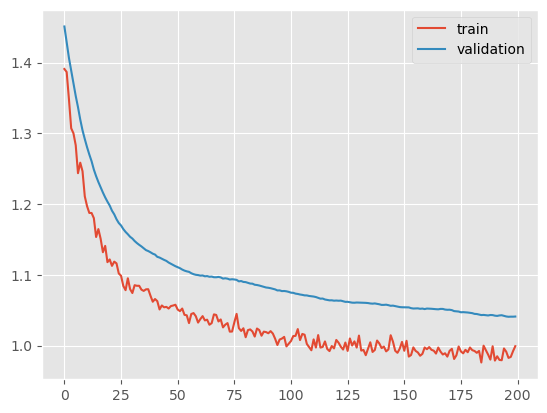

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

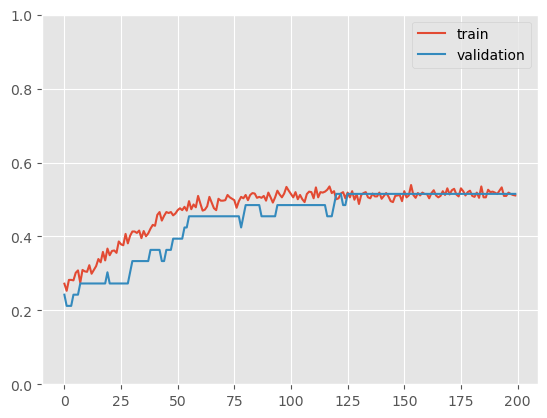

In [54]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylim(0,1)
plt.legend()
plt.show()

In [55]:
test_predictions = np.argmax(model.predict(X_test), axis=1)
accuracy = (test_predictions == y_test).sum() / y_test.shape[0]
print("Test set accuracy:", accuracy)

Test set accuracy: 0.5775862068965517


In [ ]:
#PREDICTION

In [56]:
teams_sql = ("with data as ( "
             "select distinct home_team team from predictions_fixtures "
             "where match_date between '2021-08-28' and '2021-08-29' "
             "union all "
             "select distinct away_team team from predictions_fixtures "
            "where match_date between '2021-08-28' and '2021-08-29') "
             "select distinct team from data")
teams2 = pd.read_sql(teams_sql, con)
teams2.sort_values('team', ascending=True, ignore_index=True, inplace=True)
teams2['team'] = teams2['team'].str.replace(r'\ FC','')
teams2

/Users/smarino/opt/anaconda3/envs/tf_predictor/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


,team
0,Arsenal
1,Aston Villa
2,Brentford
3,Brighton & Hove Albion
4,Burnley
5,Chelsea
6,Crystal Palace
7,Everton
8,Leeds United
9,Leicester City


In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
pred_away = ("select match_date||home_team||away_team key1, match_date, away_team team from predictions_fixtures "
               "where match_date between '2021-08-28' and '2021-08-29'")
pred_away = pd.read_sql(pred_away, con)
pred_away['team'] = pred_away['team'].str.replace(r'\ FC','')
pred_away.head()

,key1,match_date,team
0,2021-08-28Manchester City FCArsenal FC,2021-08-28,Arsenal
1,2021-08-28West Ham United FCCrystal Palace FC,2021-08-28,Crystal Palace
2,2021-08-28Norwich City FCLeicester City FC,2021-08-28,Leicester City
3,2021-08-28Newcastle United FCSouthampton FC,2021-08-28,Southampton
4,2021-08-28Brighton & Hove Albion FCEverton FC,2021-08-28,Everton


In [60]:
pred_home = ("select match_date||home_team||away_team key1, match_date, home_team team from predictions_fixtures "
             "where match_date between '2021-08-28' and '2021-08-29'")
pred_home = pd.read_sql(pred_home, con)
pred_home['team'] = pred_home['team'].str.replace(r'\ FC','')
pred_home.head()

,key1,match_date,team
0,2021-08-28Manchester City FCArsenal FC,2021-08-28,Manchester City
1,2021-08-28West Ham United FCCrystal Palace FC,2021-08-28,West Ham United
2,2021-08-28Norwich City FCLeicester City FC,2021-08-28,Norwich City
3,2021-08-28Newcastle United FCSouthampton FC,2021-08-28,Newcastle United
4,2021-08-28Brighton & Hove Albion FCEverton FC,2021-08-28,Brighton & Hove Albion


In [61]:
full_df = []
for index, row in teams2.iterrows():
    sql = (
        "with data as ("
        "select match_date, '" + row['team'] + "' as Team, "
        "case when home_team = '" + row['team'] + "' then 'H' else 'A' end as H_or_A, fthg, ftag, ftr "
        "from predictions_results "
        "where (home_team = '" + row['team'] + "' or away_team = '" + row['team'] +"') "
        "order by match_date asc ),"
        "summary as (select match_date, Team, h_or_a, "
        "case when h_or_a = 'H' then fthg else 0 end home_goals, "
        "case when h_or_a = 'H' then ftag else 0 end home_goals_concede, "
        "case when h_or_a = 'A' then ftag else 0 end away_goals, "
        "case when h_or_a = 'A' then fthg else 0 end away_goals_concede, "
        "case when h_or_a = 'A' and ftr = 'A' then 3 "
        "when h_or_a = 'H' and ftr = 'H' then 3 "
        "when h_or_a = 'H' and ftr = 'A' then 0 "
        "when h_or_a = 'A' and ftr = 'H' then 0 "
        "else 1 end points, "
        "ftr "
        "from data order by 1 desc), "
        "team as (select team, attack, midfield, defence, overall from predictions_team where team = '" + row['team'] + "' ), "
        "full_data as (select s.match_date, t.team, "
        "avg(home_goals) over (order by s.match_date asc rows between 5 preceding and current row) avg_h_goals_scored, "
        "avg(home_goals_concede) over (order by s.match_date asc rows between 5 preceding and current row) avg_h_goals_concede, "
        "avg(away_goals) over (order by s.match_date asc rows between 5 preceding and current row) avg_a_goals_scored, "
        "avg(away_goals_concede) over (order by s.match_date asc rows between 5 preceding and current row) avg_a_goals_concede, "
        "avg(points) over (order by s.match_date asc rows between 5 preceding and current row) avg_points, "
        "t.attack, t.midfield, t.defence, t.overall "
        "from summary s "
        "join team t on s.team = t.team "
        "order by 1), "
        "max_date as (select max(match_date) match_date, team from full_data group by 2) "
        "select fd.* from full_data fd join max_date m on m.match_date = fd.match_date and m.team = fd.team "
        
    )
    df = pd.read_sql(sql, con)
    full_df.append(df)
full_df = pd.concat(full_df)
full_df.head()

,match_date,team,avg_h_goals_scored,avg_h_goals_concede,avg_a_goals_scored,avg_a_goals_concede,avg_points,attack,midfield,defence,overall
0,2021-08-22,Arsenal,0.833333,0.500000,0.666667,0.500000,2.000000,83,79,79,80
0,2021-08-21,Aston Villa,0.666667,0.166667,1.000000,1.166667,1.666667,77,77,77,77
0,2021-08-21,Brentford,1.000000,0.000000,0.000000,0.000000,2.000000,74,72,71,72
0,2021-08-21,Brighton & Hove Albion,1.000000,0.500000,0.500000,0.833333,1.666667,75,76,76,75
0,2021-08-21,Burnley,0.166667,1.500000,0.333333,0.500000,0.500000,75,76,77,76


In [62]:
pred_data_home = pd.merge(pred_home, full_df, on=['team'], how='left')
pred_data_home.columns = ['key1','match_date','home_team','match_date_dup','home_avg_h_goals_scored','home_avg_h_goals_concede',
                   'home_avg_a_goals_scored','home_avg_a_goals_concede','home_avg_points','home_attack', 'home_midfield',
                   'home_defence', 'home_overall']
pred_data_home.sort_values('match_date', ascending=True, ignore_index=True, inplace=True)
#pred_data_home.head()

In [63]:
pred_data_away = pd.merge(pred_away, full_df, on=['team'], how='left')
pred_data_away.columns = ['key1','match_date','away_team','match_date_dup_a','away_avg_h_goals_scored','away_avg_h_goals_concede',
                   'away_avg_a_goals_scored','away_avg_a_goals_concede','away_avg_points','away_attack','away_midfield',
                   'away_defence', 'away_overall']
pred_data_away.sort_values('match_date', ascending=True, ignore_index=True, inplace=True)
#pred_data_away.head()

In [64]:
full_pred_data = pd.merge(pred_data_home, pred_data_away, on='key1')
full_pred_data.sort_values('match_date_x', ascending=True, ignore_index=True, inplace=True)
full_pred_data.head()

,key1,match_date_x,home_team,match_date_dup,home_avg_h_goals_scored,home_avg_h_goals_concede,home_avg_a_goals_scored,home_avg_a_goals_concede,home_avg_points,home_attack,home_midfield,home_defence,home_overall,match_date_y,away_team,match_date_dup_a,away_avg_h_goals_scored,away_avg_h_goals_concede,away_avg_a_goals_scored,away_avg_a_goals_concede,away_avg_points,away_attack,away_midfield,away_defence,away_overall
0,2021-08-28Manchester City FCArsenal FC,2021-08-28,Manchester City,2021-08-21,1.833333,0.333333,1.000000,1.166667,1.500000,85,86,83,85,2021-08-28,Arsenal,2021-08-22,0.833333,0.500000,0.666667,0.500000,2.000000,83,79,79,80
1,2021-08-28West Ham United FCCrystal Palace FC,2021-08-28,West Ham United,2021-08-23,1.166667,0.333333,1.333333,0.666667,2.166667,79,79,77,78,2021-08-28,Crystal Palace,2021-08-21,0.666667,0.833333,0.166667,1.333333,0.666667,77,75,75,76
2,2021-08-28Norwich City FCLeicester City FC,2021-08-28,Norwich City,2021-08-21,0.000000,1.500000,0.000000,1.833333,0.000000,76,73,71,73,2021-08-28,Leicester City,2021-08-23,0.833333,1.333333,0.666667,1.166667,1.000000,80,81,79,80
3,2021-08-28Newcastle United FCSouthampton FC,2021-08-28,Newcastle United,2021-08-21,1.000000,1.333333,1.000000,0.666667,1.500000,77,75,74,76,2021-08-28,Southampton,2021-08-22,1.166667,0.833333,0.166667,1.000000,1.166667,77,77,76,76
4,2021-08-28Brighton & Hove Albion FCEverton FC,2021-08-28,Brighton & Hove Albion,2021-08-21,1.000000,0.500000,0.500000,0.833333,1.666667,75,76,76,75,2021-08-28,Everton,2021-08-21,0.666667,0.333333,0.333333,1.166667,1.333333,81,79,80,79


In [65]:
data3 = full_pred_data.copy()
data3.drop(['key1','match_date_x','home_team','match_date_dup_a','match_date_y','match_date_dup','away_team','away_avg_h_goals_scored','away_avg_h_goals_concede',
           'home_avg_a_goals_scored','home_avg_a_goals_concede',], axis=1, inplace=True)
#data3.info()

In [66]:

scaler = StandardScaler()
X3 = scaler.fit_transform(data3)


In [67]:
def encoding2(x):
    if x == 1:
        return 'Home win'
    if x == 2:
        return 'Away win'
    if x == 0:
        return 'Draw'

In [70]:
predictions = np.argmax(model.predict(X3), axis=1)
home = full_pred_data['home_team']
away = full_pred_data['away_team']

pred_results = pd.DataFrame({'home':home, 'away':away, 'prediction':predictions})
pred_results['prediction'] = pred_results['prediction'].apply(lambda x: encoding2(x))
